# H2O

## Headers Imports

In [1]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model load

In [2]:
# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-large"
generation_length = 512  # The number of tokens to generate for the test

print(f"Using device: {device}")

# --- Load Model and Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loading model for TRUE baseline (no attention overhead)...")
model_baseline = AutoModelForCausalLM.from_pretrained(model_name).to(device)

print(f"Loading model for H2O test (with attentions enabled)...")
model_h2o = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True).to(device)

print("Setup complete.")

Using device: cuda
Loading model for TRUE baseline (no attention overhead)...
Loading model for H2O test (with attentions enabled)...


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Setup complete.


## Analysis

In [3]:
def analyze_inference_baseline(model, tokenizer):
    """
    Runs a true baseline test with a full KV cache and no attention overhead.
    """
    print("\n--- Running test for strategy: 'TRUE BASELINE' ---")
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values, use_cache=True)
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            past_key_values = outputs.past_key_values
            end_time = time.perf_counter()
            timings.append((end_time - start_time) * 1000)
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    print("'TRUE BASELINE' test complete.")
    return timings

def analyze_inference_h2o(model, tokenizer, window_size, heavy_hitters_to_keep):
    """
    Generates tokens and measures latency for the H2O strategy.
    """
    print(f"\n--- Running test for strategy: 'H2O' ---")
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    attention_scores = torch.zeros(0).to(device)

    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values, use_cache=True)
            current_cache_size = outputs.past_key_values[0][0].shape[2]
            
            if attention_scores.numel() < current_cache_size:
                new_scores = torch.zeros(current_cache_size - attention_scores.numel()).to(device)
                attention_scores = torch.cat([attention_scores, new_scores], dim=0)

            for layer_attention in outputs.attentions:
                current_attention_to_past = layer_attention[0, :, -1, :-1].sum(dim=0)
                if current_attention_to_past.numel() > 0:
                    attention_scores[:current_cache_size-1] += current_attention_to_past

            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            past_key_values = outputs.past_key_values

            if current_cache_size > window_size:
                _, heavy_hitter_indices = torch.topk(attention_scores, heavy_hitters_to_keep)
                num_recent_to_keep = window_size - heavy_hitters_to_keep
                recent_indices = torch.arange(current_cache_size - num_recent_to_keep, current_cache_size).to(device)
                indices_to_keep = torch.unique(torch.cat([heavy_hitter_indices, recent_indices]))
                
                past_key_values = tuple(
                    (
                        layer_past[0].index_select(2, indices_to_keep),
                        layer_past[1].index_select(2, indices_to_keep)
                    ) for layer_past in past_key_values
                )
                attention_scores = attention_scores.index_select(0, indices_to_keep)
            
            end_time = time.perf_counter()
            timings.append((end_time - start_time) * 1000)

            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    
    print("'H2O' test complete.")
    return timings

## Analysis 

In [4]:
# --- Run the Two Experiments ---
window = 128
heavy_hitters = 32 # The number of "important" past tokens to always protect

baseline_timings = analyze_inference_baseline(model_baseline, tokenizer)
h2o_timings = analyze_inference_h2o(model_h2o, tokenizer, window_size=window, heavy_hitters_to_keep=heavy_hitters)




--- Running test for strategy: 'TRUE BASELINE' ---
Generated 100/512 tokens...
Generated 200/512 tokens...
Generated 300/512 tokens...
Generated 400/512 tokens...
Generated 500/512 tokens...
'TRUE BASELINE' test complete.

--- Running test for strategy: 'H2O' ---
Generated 100/512 tokens...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.


Generated 200/512 tokens...
Generated 300/512 tokens...
Generated 400/512 tokens...
Generated 500/512 tokens...
'H2O' test complete.


## Plotting

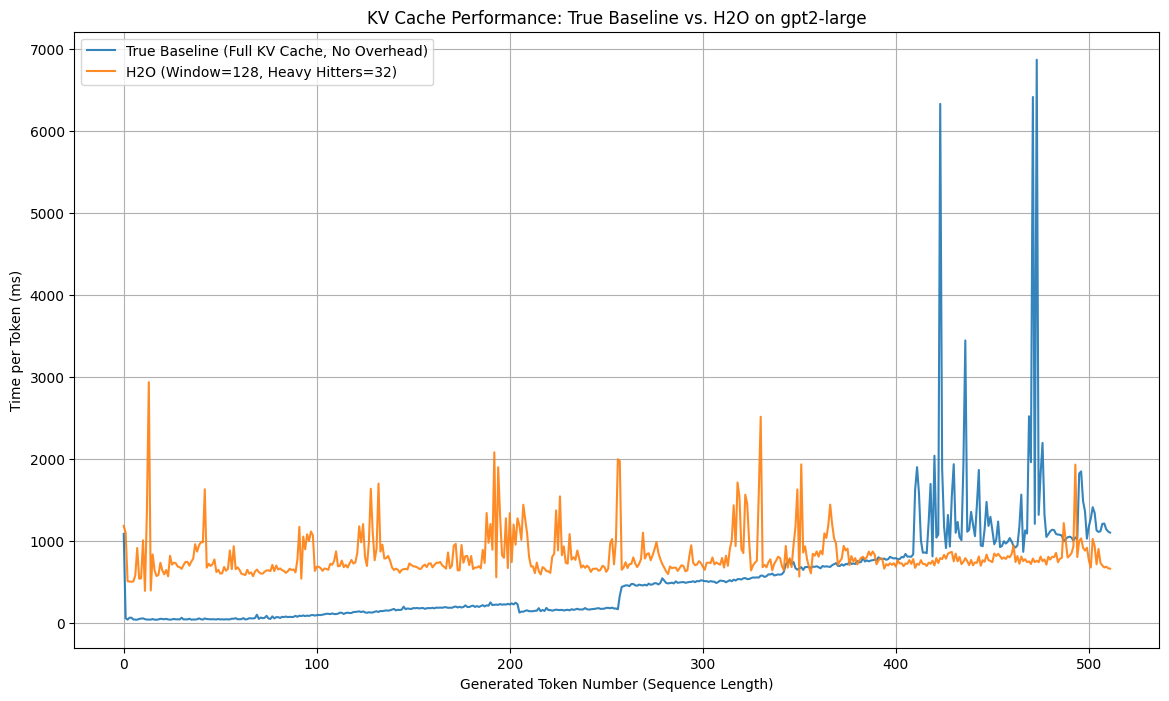

In [6]:
# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(baseline_timings, label='True Baseline (Full KV Cache, No Overhead)', alpha=0.9)
plt.plot(h2o_timings, label=f'H2O (Window={window}, Heavy Hitters={heavy_hitters})', alpha=0.9)

plt.xlabel('Generated Token Number (Sequence Length)')
plt.ylabel('Time per Token (ms)')
plt.title(f'KV Cache Performance: True Baseline vs. H2O on {model_name}')
plt.legend()
plt.grid(True)
plt.show()